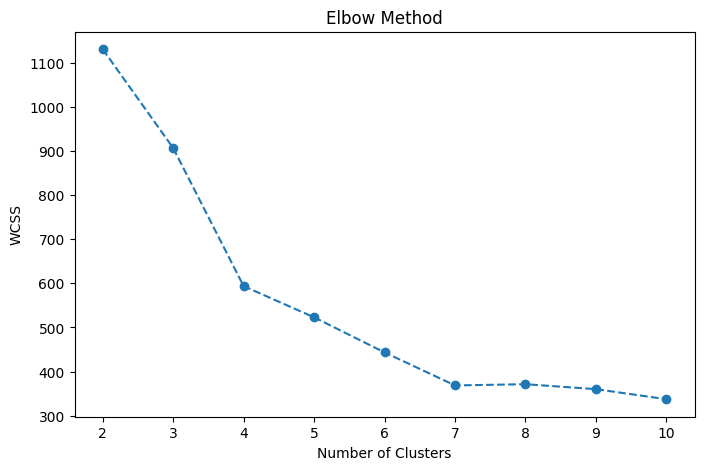

Davies-Bouldin Index: 0.9413205685620807
Silhouette Score: 0.4600918886671535


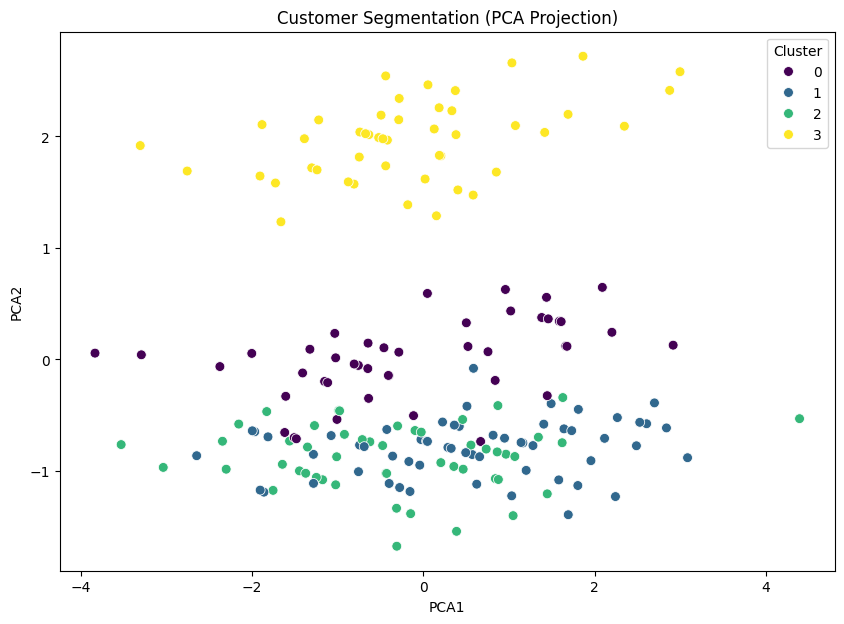

Clustering results saved to Clustered_Customers.csv.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load data
customers_url = "https://drive.google.com/uc?id=1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE"
products_url = "https://drive.google.com/uc?id=1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0"
transactions_url = "https://drive.google.com/uc?id=1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF"

customers = pd.read_csv(customers_url)
products = pd.read_csv(products_url)
transactions = pd.read_csv(transactions_url)

# Step 1: Data Preparation
# Aggregate transaction data
transactions_agg = transactions.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    AvgTransactionValue=('TotalValue', 'mean'),
    PurchaseFrequency=('TransactionID', 'count')
).reset_index()

# Merge customer and transaction data
customer_data = pd.merge(customers, transactions_agg, on='CustomerID', how='left')
customer_data.fillna(0, inplace=True)

# Select features for clustering
features = ['TotalSpend', 'AvgTransactionValue', 'PurchaseFrequency']
if 'Region' in customer_data.columns:
    region_dummies = pd.get_dummies(customer_data['Region'], prefix='Region')
    customer_data = pd.concat([customer_data, region_dummies], axis=1)
    features.extend(region_dummies.columns)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(customer_data[features])

# Step 2: Clustering
# Determine the optimal number of clusters using the Elbow method
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# Choose optimal clusters (e.g., k=4 based on Elbow Curve)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(X)

# Step 3: Clustering Evaluation
# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, customer_data['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Calculate Silhouette Score (optional)
silhouette_avg = silhouette_score(X, customer_data['Cluster'])
print(f"Silhouette Score: {silhouette_avg}")

# Step 4: Visualization
# Use PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
customer_data['PCA1'] = pca_result[:, 0]
customer_data['PCA2'] = pca_result[:, 1]

# Plot clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='viridis', s=50
)
plt.title('Customer Segmentation (PCA Projection)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster')
plt.show()

# Save results to a CSV file
customer_data.to_csv("Clustered_Customers.csv", index=False)

print("Clustering results saved to Clustered_Customers.csv.")
